# reprocess

what was saved successfully

In [1]:
import os

from keras.utils import to_categorical
from data import load_data
from results import reprocess_dir
from data import load_data

data_folder = 'ModelNet10'
(_, _), (x_test, y_test), target_names = load_data(data_folder)
y_test = to_categorical(y_test)

NAME = 'results/'
one_dir = os.listdir(NAME)[0]

model_folder = os.listdir(os.path.join(NAME, one_dir))

os.listdir(os.path.join(NAME, os.listdir(NAME)[0]))

os.path.isfile(os.path.join(NAME, one_dir, model_folder[0]))



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data_folder = 'ModelNet10'
NAME = 'results/'

one_dir = os.listdir(NAME)[0]

model_folder = os.listdir(os.path.join(NAME, one_dir))

os.listdir(os.path.join(NAME, os.listdir(NAME)[0]))

os.path.isfile(os.path.join(NAME, one_dir, model_folder[0]))

True

In [3]:
(_, _), (x_test, y_test), target_names = load_data(data_folder)
# x_train, y_train, x_val, y_val = stratified_shuffle(x_train, y_train, test_size=.1)
# x_train, y_train = upsample_classes(x_train, y_train)
# y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)

In [2]:
reprocess_dir(os.path.join(NAME, one_dir), x_test, y_test, target_names)

In [3]:
print(os.path.join(NAME, one_dir))

results/ModelNet10_base_model_acc_085242_map_076423


In [11]:
folders = []
root = 'results'
for sub_dir in os.listdir(root):
    print(os.path.join(root, sub_dir))
    folders.append(os.path.join(root, sub_dir))

results/ModelNet10_base_model_acc_085242_map_076423
results/ModelNet10_base_model_acc_085683_map_079138
results/ModelNet40_base_model_acc_073622_map_054835
results/ModelNet40_base_model_acc_073744_map_055776
results/ModelNet10_base_model_acc_088656_map_082756
results/ModelNet10_base_model_acc_088436_map_082462
results/ModelNet10_base_model_acc_083921_map_075976
results/ModelNet40_base_model_acc_068882_map_048273
results/ModelNet40_base_model_acc_061912_map_041612
results/ModelNet40_base_model_acc_075486_map_058689
results/ModelNet10_base_model_acc_087775_map_080771
results/ModelNet40_two_convcaps_layers_acc_007_map_013858
results/ModelNet10_base_model_acc_072467_map_059002
results/.ipynb_checkpoints
results/ModelNet10_base_model_acc_087996_map_081304
results/ModelNet40_base_model_acc_076297_map_05917
results/ModelNet10_base_model_acc_087445_map_081544
results/ModelNet10_base_model_acc_011013_map_019332
results/ModelNet10_base_model_acc_08304_map_072242
results/ModelNet10_base_model_acc

In [24]:
list(filter(lambda x: 'ModelNet40' in x, folders))

['results/ModelNet40_base_model_acc_073622_map_054835',
 'results/ModelNet40_base_model_acc_073744_map_055776',
 'results/ModelNet40_base_model_acc_068882_map_048273',
 'results/ModelNet40_base_model_acc_061912_map_041612',
 'results/ModelNet40_base_model_acc_075486_map_058689',
 'results/ModelNet40_two_convcaps_layers_acc_007_map_013858',
 'results/ModelNet40_base_model_acc_076297_map_05917',
 'results/ModelNet40_base_model_acc_004052_map_007831']

In [16]:
data_folder = 'ModelNet40'
(_, _), (x_test, y_test), target_names = load_data(data_folder)
y_test = to_categorical(y_test)

In [18]:
model40_folders = [i for i in folders if '40' in i]

In [19]:
model40_folders

['results/ModelNet40_base_model_acc_073622_map_054835',
 'results/ModelNet40_base_model_acc_073744_map_055776',
 'results/ModelNet40_base_model_acc_068882_map_048273',
 'results/ModelNet40_base_model_acc_061912_map_041612',
 'results/ModelNet40_base_model_acc_075486_map_058689',
 'results/ModelNet40_two_convcaps_layers_acc_007_map_013858',
 'results/ModelNet40_base_model_acc_076297_map_05917',
 'results/ModelNet40_base_model_acc_004052_map_007831']

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


precisions_done_calculating0
precisions_done_calculating100
precisions_done_calculating200
precisions_done_calculating300
precisions_done_calculating400
precisions_done_calculating500
precisions_done_calculating600
precisions_done_calculating700
precisions_done_calculating800
precisions_done_calculating900
precisions_done_calculating1000
precisions_done_calculating1100
precisions_done_calculating1200
precisions_done_calculating1300
precisions_done_calculating1400
precisions_done_calculating1500
precisions_done_calculating1600
precisions_done_calculating1700
precisions_done_calculating1800
precisions_done_calculating1900
precisions_done_calculating2000
precisions_done_calculating2100
precisions_done_calculating2200
precisions_done_calculating2300
precisions_done_calculating2400
Normalized confusion matrix
[[0.92 0.   0.   ... 0.   0.   0.  ]
 [0.   0.95 0.   ... 0.   0.   0.  ]
 [0.   0.   0.1  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.73 0.   0.  ]
 [0.   0.   0.02 ... 0.   0.78 

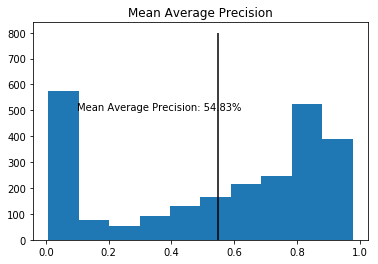

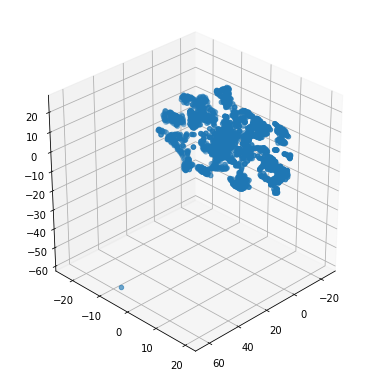

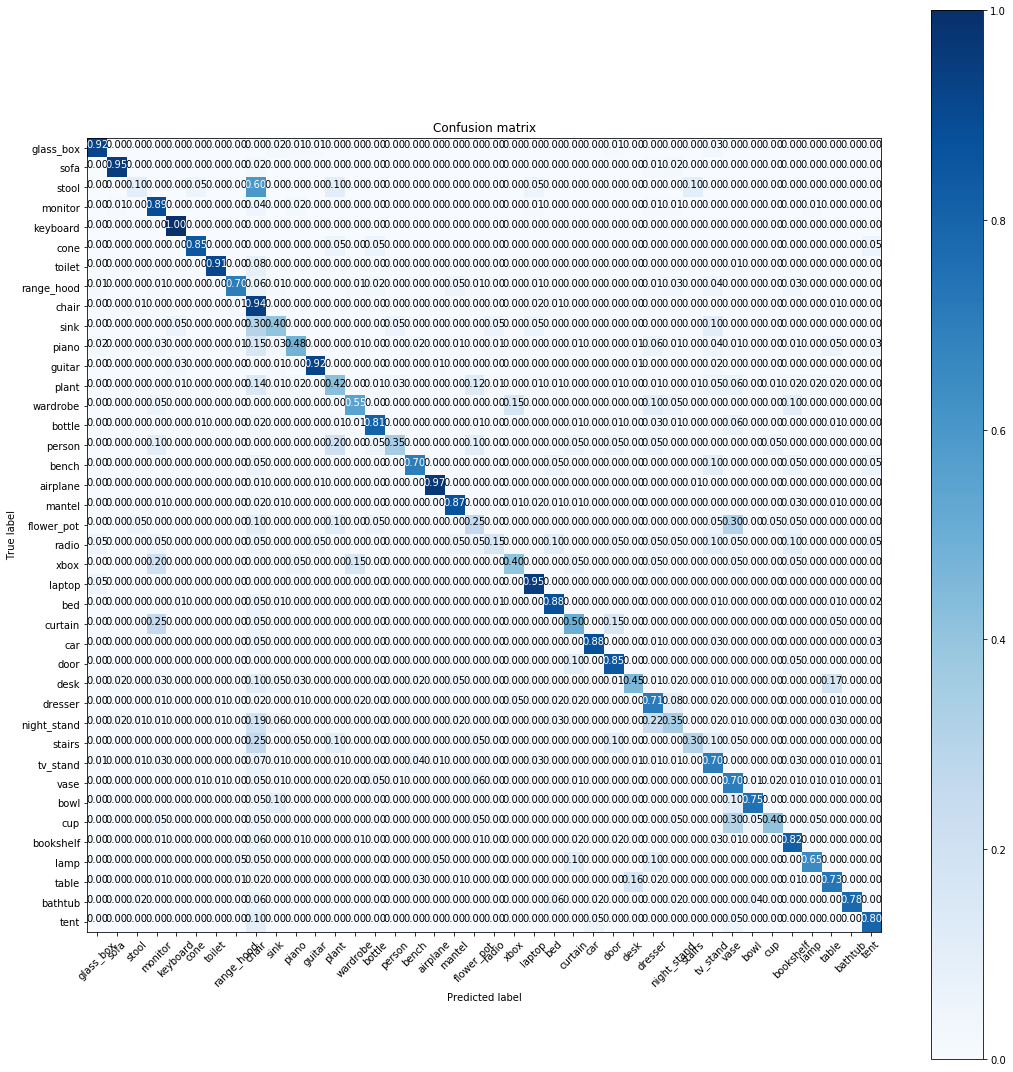

In [21]:
reprocess_dir(model40_folders[1], x_test, y_test, target_names)